In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Assignment 3

### Task 3.1

In [11]:
def arbitrary_poly(params):
    return np.poly1d(params[::-1])

# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = np.random.uniform(-3, 3, 5) # 5 params -> quartic model
y_model = arbitrary_poly(true_params)
u = np.linspace(start=-1, stop=1, num=10)

# Hyperparameters for the type of noise-generating distribution.
alpha = 0         # probability in mixture model
mean = 0          # mean parameter 
sigma = 1         # std dev parameter Gaussian
beta = 1          # scaling parameter Laplacian
N = 10            # number of samples

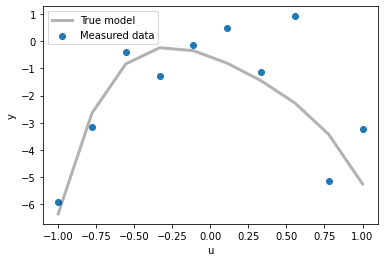

In [12]:
# The Laplace probability density function:
# Also available in library "scipy.stats.laplace"
def laplace_pdf(x, loc, scale):
    return (1.0/(2.0 * scale)) * np.exp( -np.abs(x-loc) / scale)

# Generate data points
def generate_data(model=y_model, inputs=u, alpha=alpha, mean=mean, sigma=sigma, beta=beta, N=N):
    y_true = y_model(u)

    # Generate noise
    noise = np.zeros(N)
    for i in range(N):
        if np.random.uniform(0, 1) <= alpha:
            # Gaussian when event with probability alpha
            noise[i] = np.random.normal(mean, sigma)
        else:
            # Laplacian when event with probability alpha - 1
            noise[i] = np.random.laplace(mean, beta)

    # Add noise to the generated data points - thus simulating measurement
    y = y_true + noise
    return y

y = generate_data()
        
# Plot measured data
plt.scatter(u, y, label=r"Measured data")
plt.plot(u, y_model(u), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("u")
plt.ylabel("y");

### Task 3.2

In [13]:
def LS_estimate(measured_data, input_data, model_order, num_samples):
    if model_order == 1:
        LS_params = np.array([np.average(measured_data)])
        LS_params = LS_params.tolist()
        return LS_params
    # Step 1
    # Matrix form
    u_tensor_0 = np.reshape(input_data,(num_samples,1))
    ones_vec = np.ones((num_samples,1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)
    
    for i in range(2,model_order):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)
    
    # Step 2
    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
    u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
    
    # Step 3
    u_transpose_dot_y = np.dot(u_tensor.T, measured_data)  # calculating dot product
    
    # Step 4
    LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)

    # Recreate model based on LS estimate:
    LS_params = LS_params.tolist()
    
    return LS_params

In [14]:
def log_lik(par_vec, y, x):
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = laplace_pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

In [15]:
import scipy.optimize as optimize

def MLE_estimate(lik_func, measured_data, input_data, model_order, num_samples):
    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess verctor has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(model_order+1)
    init_guess[-1] = num_samples

    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(fun = lik_func,
                                x0 = init_guess,
                                #options={'disp': True},
                                args = (measured_data, input_data))

    MLE_params = opt_res.x[:-1]
    
    return MLE_params

In [16]:
# Split datasets
def split_datasets(u, y):
    # Split the dataset into train and test sets
    split_index = len(u)//2
    X_train, X_test = u[:split_index], u[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_datasets(u, y)

# Guess what order the model is:
order_guesses = np.arange(1,11, dtype="int") # number coincides with # of parameters, i.e. (order+1)

LS_params = []
MLE_params = []

for o in order_guesses:
    LS_params.append(LS_estimate(y_train, X_train, o, X_train.size))
    MLE_params.append(MLE_estimate(log_lik, y_train, X_train, o, X_train.size))
    
y_predict_LS = []
y_predict_MLE = []

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
for i, params in enumerate(LS_params):
    model = arbitrary_poly(params)
    y_predict_LS.append(model)
    #ax1.plot(X_test, model(X_test), "--", alpha = 1, lw=3, label="LS estimate order {}".format(i))
for i, params in enumerate(MLE_params):
    model = arbitrary_poly(params)
    #ax2.plot(X_test, model(X_test), "--", alpha = 1, lw=3, label="MLE estimate order {}".format(i))
    y_predict_MLE.append(model)
    
#ax1.scatter(X_test, y_test, alpha = 0.2 ,lw=3, label="Measurements")
#ax1.plot(u, y_model(u), alpha = 0.4 ,lw=3, label="True model")
#ax1.legend()
#ax2.scatter(X_test, y_test, alpha = 0.2 ,lw=3, label="Measurements")
#ax2.plot(u, y_model(u), alpha = 0.4 ,lw=3, label="True model")
#ax2.legend()

### Task 3.3

In [17]:
# Define functions for performance indexes
def RMSE(model, u, y):
    return np.sqrt(np.mean((y - model(u))**2))

def RSS(model, u, y):
    return np.sum((y - model(u))**2)

def MAD(model, u, y):
    return np.sum(np.abs(y - model(u)))

def FVU(model, u, y):
    rss = RSS(model, u, y)
    var = np.sum((y - np.mean(y))**2)
    return rss/var

def R_squared(model, u, y):
    return 1-FVU(model, u, y)

def FIT(model, u, y):
    rss = RSS(model, u, y)
    var = np.sum((y - np.mean(y))**2)
    return 1 - np.sqrt(rss)/np.sqrt(var)

In [18]:
LS_performance_train = np.zeros((10, 6))
MLE_performance_train = np.zeros((10, 6))
LS_performance_test = np.zeros((10, 6))
MLE_performance_test = np.zeros((10, 6))

for i, model in enumerate(y_predict_LS):
    LS_performance_train[i][0] = RMSE(model, X_train, y_train)
    LS_performance_train[i][1] = RSS(model, X_train, y_train)
    LS_performance_train[i][2] = MAD(model, X_train, y_train)
    LS_performance_train[i][3] = FVU(model, X_train, y_train)
    LS_performance_train[i][4] = R_squared(model, X_train, y_train)
    LS_performance_train[i][5] = FIT(model, X_train, y_train)
    
    LS_performance_test[i][0] = RMSE(model, X_test, y_test)
    LS_performance_test[i][1] = RSS(model, X_test, y_test)
    LS_performance_test[i][2] = MAD(model, X_test, y_test)
    LS_performance_test[i][3] = FVU(model, X_test, y_test)
    LS_performance_test[i][4] = R_squared(model, X_test, y_test)
    LS_performance_test[i][5] = FIT(model, X_test, y_test)

for i, model in enumerate(y_predict_MLE):
    MLE_performance_train[i][0] = RMSE(model, X_train, y_train)
    MLE_performance_train[i][1] = RSS(model, X_train, y_train)
    MLE_performance_train[i][2] = MAD(model, X_train, y_train)
    MLE_performance_train[i][3] = FVU(model, X_train, y_train)
    MLE_performance_train[i][4] = R_squared(model, X_train, y_train)
    MLE_performance_train[i][5] = FIT(model, X_train, y_train)
    
    MLE_performance_test[i][0] = RMSE(model, X_test, y_test)
    MLE_performance_test[i][1] = RSS(model, X_test, y_test)
    MLE_performance_test[i][2] = MAD(model, X_test, y_test)
    MLE_performance_test[i][3] = FVU(model, X_test, y_test)
    MLE_performance_test[i][4] = R_squared(model, X_test, y_test)
    MLE_performance_test[i][5] = FIT(model, X_test, y_test)

### Task 3.4

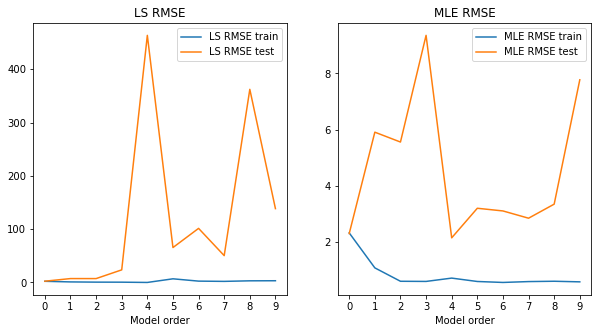

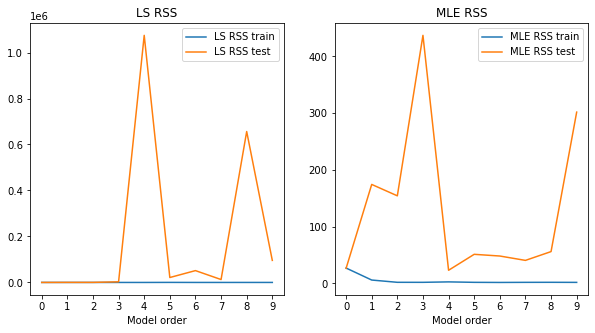

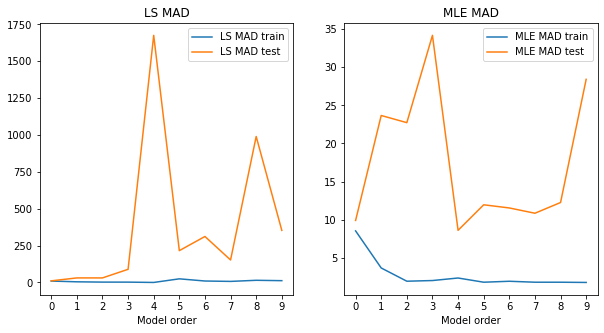

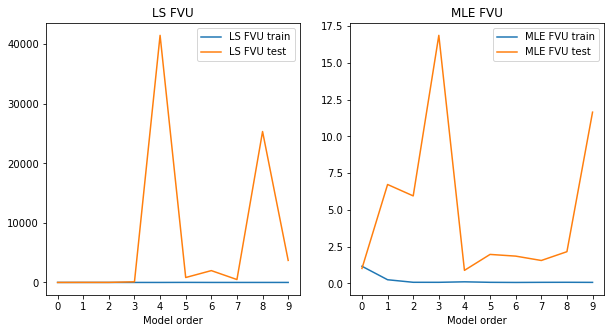

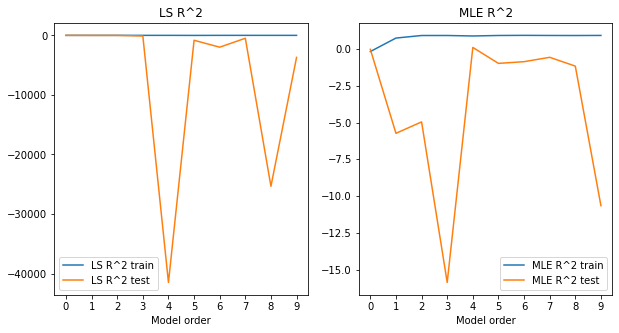

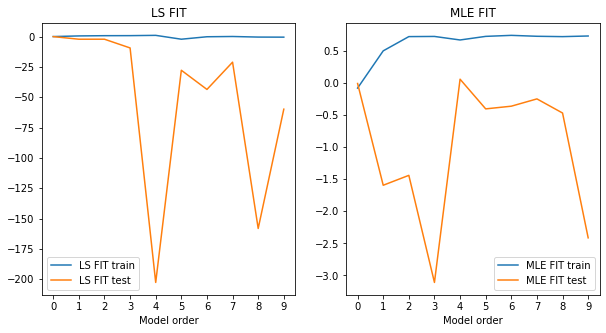

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(order_guesses-1, LS_performance_train[:,0], label="LS RMSE train")
ax1.plot(order_guesses-1, LS_performance_test[:,0], label="LS RMSE test")
ax2.plot(order_guesses-1, MLE_performance_train[:,0], label="MLE RMSE train")
ax2.plot(order_guesses-1, MLE_performance_test[:,0], label="MLE RMSE test")
ax1.legend()
ax2.legend()
ax1.set_title("LS RMSE")
ax2.set_title("MLE RMSE")
plt.setp(ax1, xlabel='Model order', xticks = order_guesses-1)
plt.setp(ax2, xlabel='Model order', xticks = order_guesses-1)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(order_guesses-1, LS_performance_train[:,1], label="LS RSS train")
ax1.plot(order_guesses-1, LS_performance_test[:,1], label="LS RSS test")
ax2.plot(order_guesses-1, MLE_performance_train[:,1], label="MLE RSS train")
ax2.plot(order_guesses-1, MLE_performance_test[:,1], label="MLE RSS test")
ax1.legend()
ax2.legend()
ax1.set_title("LS RSS")
ax2.set_title("MLE RSS")
plt.setp(ax1, xlabel='Model order', xticks = order_guesses-1)
plt.setp(ax2, xlabel='Model order', xticks = order_guesses-1)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(order_guesses-1, LS_performance_train[:,2], label="LS MAD train")
ax1.plot(order_guesses-1, LS_performance_test[:,2], label="LS MAD test")
ax2.plot(order_guesses-1, MLE_performance_train[:,2], label="MLE MAD train")
ax2.plot(order_guesses-1, MLE_performance_test[:,2], label="MLE MAD test")
ax1.legend()
ax2.legend()
ax1.set_title("LS MAD")
ax2.set_title("MLE MAD")
plt.setp(ax1, xlabel='Model order', xticks = order_guesses-1)
plt.setp(ax2, xlabel='Model order', xticks = order_guesses-1)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(order_guesses-1, LS_performance_train[:,3], label="LS FVU train")
ax1.plot(order_guesses-1, LS_performance_test[:,3], label="LS FVU test")
ax2.plot(order_guesses-1, MLE_performance_train[:,3], label="MLE FVU train")
ax2.plot(order_guesses-1, MLE_performance_test[:,3], label="MLE FVU test")
ax1.legend()
ax2.legend()
ax1.set_title("LS FVU")
ax2.set_title("MLE FVU")
plt.setp(ax1, xlabel='Model order', xticks = order_guesses-1)
plt.setp(ax2, xlabel='Model order', xticks = order_guesses-1)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(order_guesses-1, LS_performance_train[:,4], label="LS R^2 train")
ax1.plot(order_guesses-1, LS_performance_test[:,4], label="LS R^2 test")
ax2.plot(order_guesses-1, MLE_performance_train[:,4], label="MLE R^2 train")
ax2.plot(order_guesses-1, MLE_performance_test[:,4], label="MLE R^2 test")
ax1.legend()
ax2.legend()
ax1.set_title("LS R^2")
ax2.set_title("MLE R^2")
plt.setp(ax1, xlabel='Model order', xticks = order_guesses-1)
plt.setp(ax2, xlabel='Model order', xticks = order_guesses-1)
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(order_guesses-1, LS_performance_train[:,5], label="LS FIT train")
ax1.plot(order_guesses-1, LS_performance_test[:,5], label="LS FIT test")
ax2.plot(order_guesses-1, MLE_performance_train[:,5], label="MLE FIT train")
ax2.plot(order_guesses-1, MLE_performance_test[:,5], label="MLE FIT test")
ax1.legend()
ax2.legend()
ax1.set_title("LS FIT")
ax2.set_title("MLE FIT")
plt.setp(ax1, xlabel='Model order', xticks = order_guesses-1)
plt.setp(ax2, xlabel='Model order', xticks = order_guesses-1)
plt.show()

### Task 3.5

The MLE plots show that model order 0-1 is too low as the performance on the training set increases for all the performance indexes when increasing model order. At model order 2 and above the performance on the training set stays mostly constant for all the MLE models. This shows that model order 0 and 1 is underfitting the data and not capturing all the information. When looking at the performance on test data we see that model order 0 and 4 performs the best, which leads to the conclusion that model order 4 is the correct one. This also infers that orders higher than 4 have more overfitting than model order 4 as the performance on the test set drops. 

Increasing the model order reduces bias and introduces more variance. For model orders above order 4 the reduction in bias is very low, while the variance increase still is significant, which reduces the performance on unseen data for orders higher than order 4.